In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, GRU, Dropout
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.losses import MeanAbsolutePercentageError
import tensorflow as tf

2022-11-18 00:24:10.026632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    
    cols, names = list(), list()
    
    # 입력값의 순서 (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # 예측의 순서 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # 합치기
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # NaN 값의 row를 제거
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [3]:
data = pd.read_csv('월별공급량및비중all.csv')
ind = data["도시가스(톤)_산업용"]
ind.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
ind = ind.to_frame()
ind.columns=['gas']
ind.index = pd.DatetimeIndex(ind.index.values,
                               freq=ind.index.inferred_freq)

# rp = pd.read_csv('상업용 상대가격(기준=2015)all.csv')
# data2 = rp['RP(상대가격)']
# kospi = pd.read_csv('코스피지수.csv')
# data2 = kospi['종가']
dollar = pd.read_csv('USD_KRW 내역.csv')
data2 = dollar['종가']
data2.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
ind['rp'] = data2

temp = pd.read_csv('서울월별기온.csv', engine='python', encoding='CP949')
data3 = temp['평균기온(℃)']
data3.dropna(inplace=True)
data3.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
ind['temp'] = data3
# ind.dropna(inplace=True)

sc = MinMaxScaler(feature_range=(0, 1))
ind_sc = sc.fit_transform(ind.values)
ind_sc = pd.DataFrame(ind_sc)
ind_sc.index = ind.index

reframed = series_to_supervised(ind_sc, 12, 1)
ind_sc, reframed

(                   0         1         2
 1996-01-01  0.060116  0.007636  0.138889
 1996-02-01  0.045653  0.004690  0.155556
 1996-03-01  0.037249  0.004363  0.336111
 1996-04-01  0.020386  0.000000  0.483333
 1996-05-01  0.002725  0.010581  0.711111
 ...              ...       ...       ...
 2020-08-01  0.464516  0.446894  0.936111
 2020-09-01  0.537632  0.421489  0.794444
 2020-10-01  0.618987  0.390772  0.597222
 2020-11-01  0.689252  0.361134  0.422222
 2020-12-01  0.847080  0.334028  0.191667
 
 [300 rows x 3 columns],
             var1(t-12)  var2(t-12)  var3(t-12)  var1(t-11)  var2(t-11)  \
 1997-01-01    0.060116    0.007636    0.138889    0.045653    0.004690   
 1997-02-01    0.045653    0.004690    0.155556    0.037249    0.004363   
 1997-03-01    0.037249    0.004363    0.336111    0.020386    0.000000   
 1997-04-01    0.020386    0.000000    0.483333    0.002725    0.010581   
 1997-05-01    0.002725    0.010581    0.711111    0.000374    0.035942   
 ...               

In [4]:
reframed

,var1(t-12),var2(t-12),var3(t-12),var1(t-11),var2(t-11),var3(t-11),var1(t-10),var2(t-10),var3(t-10),var1(t-9),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1997-01-01,0.060116,0.007636,0.138889,0.045653,0.004690,0.155556,0.037249,0.004363,0.336111,0.020386,...,0.602778,0.055208,0.055304,0.369444,0.078206,0.072812,0.244444,0.082705,0.094628,0.108333
1997-02-01,0.045653,0.004690,0.155556,0.037249,0.004363,0.336111,0.020386,0.000000,0.483333,0.002725,...,0.369444,0.078206,0.072812,0.244444,0.082705,0.094628,0.108333,0.060484,0.093537,0.219444
1997-03-01,0.037249,0.004363,0.336111,0.020386,0.000000,0.483333,0.002725,0.010581,0.711111,0.000374,...,0.244444,0.082705,0.094628,0.108333,0.060484,0.093537,0.219444,0.050742,0.127897,0.388889
1997-04-01,0.020386,0.000000,0.483333,0.002725,0.010581,0.711111,0.000374,0.035942,0.819444,0.003166,...,0.108333,0.060484,0.093537,0.219444,0.050742,0.127897,0.388889,0.036955,0.124080,0.561111
1997-05-01,0.002725,0.010581,0.711111,0.000374,0.035942,0.819444,0.003166,0.037797,0.877778,0.000000,...,0.219444,0.050742,0.127897,0.388889,0.036955,0.124080,0.561111,0.033709,0.124352,0.672222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,0.525643,0.470412,0.955556,0.536742,0.457966,0.827778,0.648529,0.426496,0.655556,0.742178,...,0.700000,0.451833,0.459264,0.863889,0.494435,0.453057,0.869444,0.464516,0.446894,0.936111
2020-09-01,0.536742,0.457966,0.827778,0.648529,0.426496,0.655556,0.742178,0.438996,0.411111,0.786142,...,0.863889,0.494435,0.453057,0.869444,0.464516,0.446894,0.936111,0.537632,0.421489,0.794444
2020-10-01,0.648529,0.426496,0.655556,0.742178,0.438996,0.411111,0.786142,0.409948,0.238889,0.712147,...,0.869444,0.464516,0.446894,0.936111,0.537632,0.421489,0.794444,0.618987,0.390772,0.597222
2020-11-01,0.742178,0.438996,0.411111,0.786142,0.409948,0.238889,0.712147,0.454562,0.244444,0.654120,...,0.936111,0.537632,0.421489,0.794444,0.618987,0.390772,0.597222,0.689252,0.361134,0.422222


In [5]:
values = reframed.values
split_rate = int(0.75*len(values))
train = values[:split_rate, :]
test = values[split_rate:, :]
train, test

(array([[0.06011619, 0.00763567, 0.13888889, ..., 0.08270529, 0.09462776,
         0.10833333],
        [0.04565268, 0.00469048, 0.15555556, ..., 0.06048367, 0.09353695,
         0.21944444],
        [0.03724932, 0.00436324, 0.33611111, ..., 0.05074225, 0.12789746,
         0.38888889],
        ...,
        [0.76690859, 0.30824107, 0.63888889, ..., 0.69951958, 0.3210799 ,
         0.63333333],
        [0.87774433, 0.30489228, 0.37222222, ..., 0.71725796, 0.36454868,
         0.45      ],
        [0.92027561, 0.29588219, 0.19444444, ..., 0.88477181, 0.34322334,
         0.11944444]]),
 array([[0.85820314, 0.32954459, 0.18055556, ..., 0.72671512, 0.35249523,
         0.175     ],
        [0.7195774 , 0.31389146, 0.25277778, ..., 0.58870113, 0.35154622,
         0.22777778],
        [0.76382502, 0.31240796, 0.41944444, ..., 0.6505196 , 0.35968367,
         0.375     ],
        ...,
        [0.64852874, 0.42649577, 0.65555556, ..., 0.61898673, 0.39077175,
         0.59722222],
        [0.7

In [6]:
print('======================== reframed ==========================')
print(len(train))
print(len(test))

# 입력값과 출력값으로 분리
n_shifts = 12
n_features = 3
n_obs = n_shifts * n_features
# train_X, train_y = train[:, :n_obs], train[:, -n_features]
# test_X, test_y = test[:, :n_obs], test[:, -n_features]
train_X, train_y = train[:, :n_obs], train[:, -n_features:]
test_X, test_y = test[:, :n_obs], test[:, -n_features:]
print(train_X.shape, len(train_X), train_y.shape)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

======================== reframed ==========================
216
72
(216, 36) 216 (216, 3)
(216, 36) (216, 3) (72, 36) (72, 3)


In [7]:
# 입력값 3D로 reshape [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_shifts, n_features))
test_X = test_X.reshape((test_X.shape[0], n_shifts, n_features))
print('================ reshape 후 train_X 의 shape ===============')
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

================ reshape 후 train_X 의 shape ===============
(216, 12, 3) (216, 3) (72, 12, 3) (72, 3)


In [8]:
K.clear_session()

# tf.random.set_seed(0)
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(300, activation='relu'))
model.add(Dense(n_features))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

2022-11-18 00:24:17.206725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 300)           364800    
                                                                 
 dropout (Dropout)           (None, 12, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 300)               721200    
                                                                 
 dense (Dense)               (None, 3)                 903       
                                                                 
Total params: 1,086,903
Trainable params: 1,086,903
Non-trainable params: 0
_________________________________________________________________


In [9]:
early_stop = EarlyStopping(monitor='loss', patience=50, verbose=1)
h = model.fit(train_X, train_y, epochs=300, validation_data=[test_X, test_y],
         batch_size=10, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/300
22/22 [==============================] - 4s 92ms/step - loss: 0.0747 - val_loss: 0.0372
Epoch 2/300
22/22 [==============================] - 1s 62ms/step - loss: 0.0695 - val_loss: 0.0414
Epoch 3/300
22/22 [==============================] - 1s 50ms/step - loss: 0.0514 - val_loss: 0.0416
Epoch 4/300
22/22 [==============================] - 1s 58ms/step - loss: 0.0556 - val_loss: 0.0433
Epoch 5/300
22/22 [==============================] - 1s 58ms/step - loss: 0.0462 - val_loss: 0.0271
Epoch 6/300
22/22 [==============================] - 1s 63ms/step - loss: 0.0326 - val_loss: 0.0262
Epoch 7/300
22/22 [==============================] - 2s 71ms/step - loss: 0.0326 - val_loss: 0.0222
Epoch 8/300
22/22 [==============================] - 2s 75ms/step - loss: 0.0272 - val_loss: 0.0068
Epoch 9/300
22/22 [==============================] - 1s 66ms/step - loss: 0.0190 - val_loss: 0.0238
Epoch 10/300
22/22 [==============================] - 1s 56ms/step - loss: 0.0296 - val_loss: 0.0125

Minimum Train Loss: 0.0024
Minimum Validation Loss: 0.0020
dict_keys(['loss', 'val_loss'])


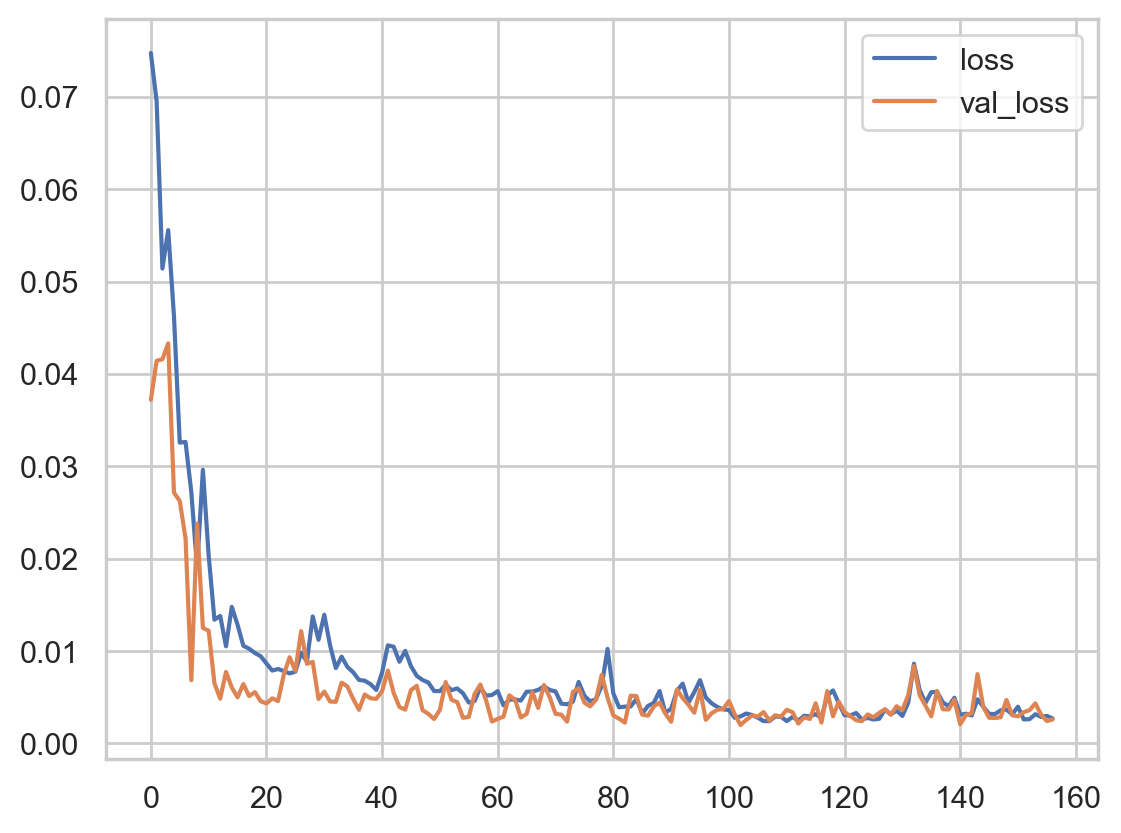

In [10]:
history_df=pd.DataFrame(h.history)
print("Minimum Train Loss: {:0.4f}".format(history_df['loss'].min()))
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print(h.history.keys())
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [11]:
yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], n_shifts*n_features)) #학습할때만 3D로 차원변경해서 다시 2차원으로 되돌림

3/3 [==============================] - 0s 16ms/step


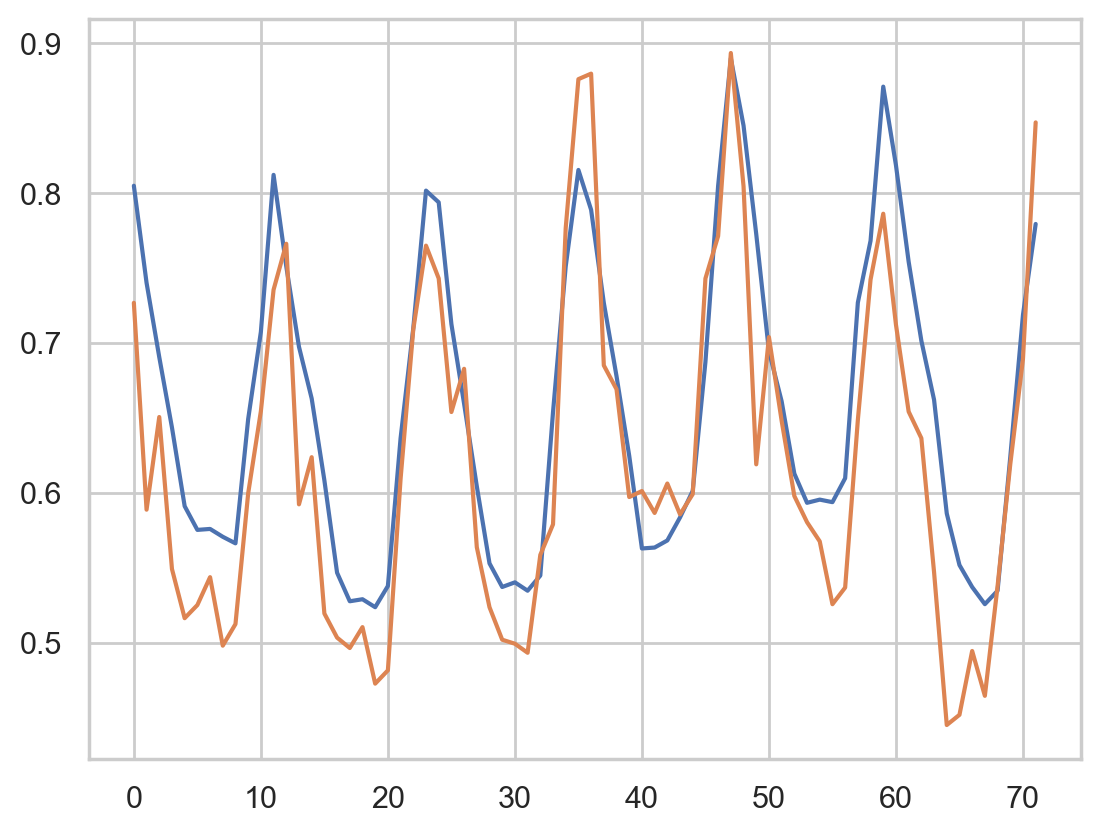

In [12]:
plt.figure()
plt.plot(yhat[:,0])
plt.plot(test_y[:,0])

In [13]:
# inv_yhat = concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = sc.inverse_transform(yhat)
inv_yhat = inv_yhat[:,0]

In [14]:
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = sc.inverse_transform(test_y)
inv_y = inv_y[:,0]

In [15]:
inv_yhat = pd.DataFrame(inv_yhat)
inv_yhat.index = reframed[split_rate:].index
inv_y = pd.DataFrame(inv_y)
inv_y.index = reframed[split_rate:].index

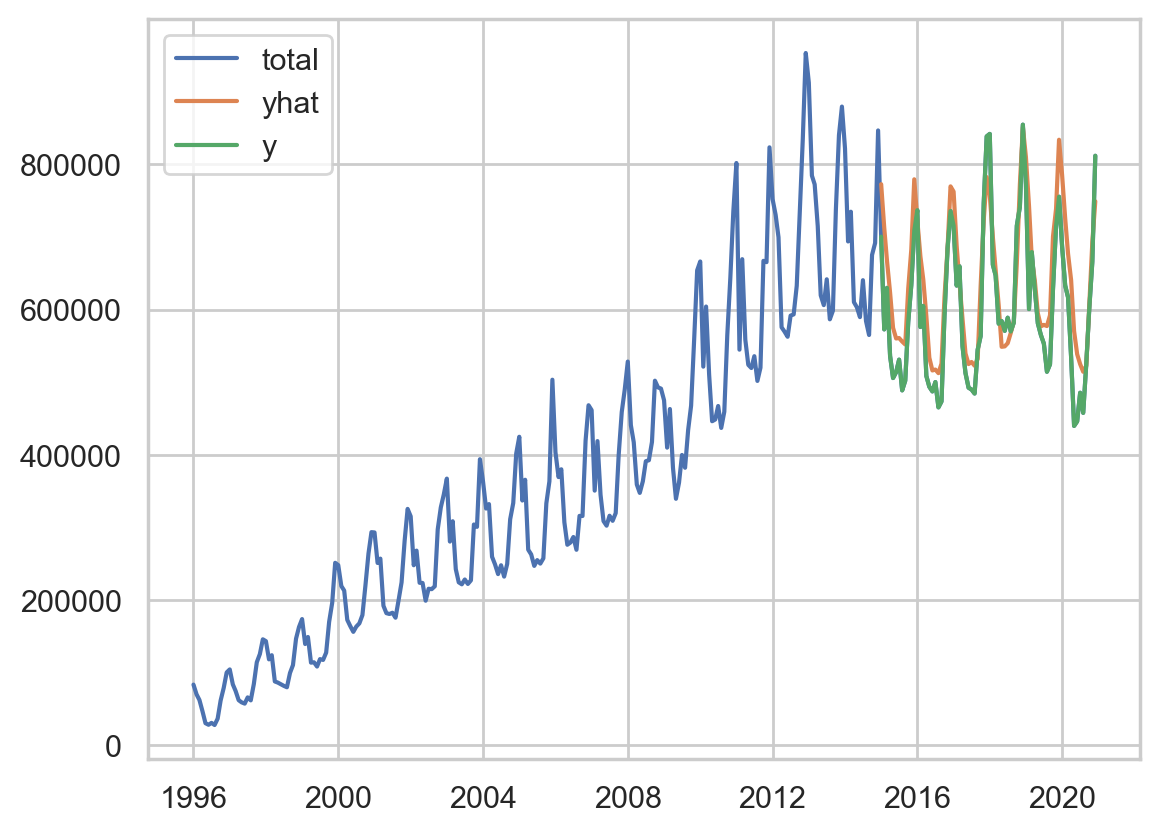

In [16]:
plt.figure()
plt.plot(ind['gas'])
plt.plot(inv_yhat)
plt.plot(inv_y)
plt.legend(['total', 'yhat', 'y'])

In [17]:
print(reframed['2020-12-01':])
print(reframed['2020-12-01':].shift(axis=1, periods=-n_features).drop(['var1(t)', 'var2(t)', 'var3(t)'], axis=1))

new_X = reframed['2020-12-01':].shift(axis=1, periods=-n_features).drop(['var1(t)', 'var2(t)', 'var3(t)'], axis=1).values
new_X_t = new_X.reshape(new_X.shape[0], n_shifts, n_features)
print('new_X: ', new_X)
print('new_X_t: ', new_X_t)
print(new_X_t.shape)
print(type(new_X_t))

            var1(t-12)  var2(t-12)  var3(t-12)  var1(t-11)  var2(t-11)  \
2020-12-01    0.786142    0.409948    0.238889    0.712147    0.454562   

            var3(t-11)  var1(t-10)  var2(t-10)  var3(t-10)  var1(t-9)  ...  \
2020-12-01    0.244444     0.65412    0.460267    0.269444   0.636397  ...   

            var3(t-3)  var1(t-2)  var2(t-2)  var3(t-2)  var1(t-1)  var2(t-1)  \
2020-12-01   0.794444   0.618987   0.390772   0.597222   0.689252   0.361134   

            var3(t-1)  var1(t)   var2(t)   var3(t)  
2020-12-01   0.422222  0.84708  0.334028  0.191667  

[1 rows x 39 columns]
            var1(t-12)  var2(t-12)  var3(t-12)  var1(t-11)  var2(t-11)  \
2020-12-01    0.712147    0.454562    0.244444     0.65412    0.460267   

            var3(t-11)  var1(t-10)  var2(t-10)  var3(t-10)  var1(t-9)  ...  \
2020-12-01    0.269444    0.636397    0.480011    0.413889   0.547036  ...   

            var3(t-4)  var1(t-3)  var2(t-3)  var3(t-3)  var1(t-2)  var2(t-2)  \
2020-12-01   0.794

In [18]:
new_Y_pred = model.predict(new_X_t)
new_Y_pred

1/1 [==============================] - 0s 23ms/step


array([[0.740458 , 0.3855507, 0.1698322]], dtype=float32)

In [19]:
from pandas.tseries.offsets import DateOffset
pred_date = [reframed.index[-1] + DateOffset(months=x) for x in range(0,169)]
pred_date = pd.DataFrame(index=pred_date[1:], columns=reframed.columns)
pred_date.iloc[0,:-n_features] = reframed['2020-12-01':].shift(axis=1, periods=-n_features).drop(['var1(t)', 'var2(t)', 'var3(t)'], axis=1)
print(pred_date)

new_X = np.reshape(pred_date.iloc[0,:-n_features].values, (-1, n_shifts, n_features))
new_X = np.asarray(new_X).astype('float32')
print(new_X.shape)
print('new_X: ', new_X)

           var1(t-12) var2(t-12) var3(t-12) var1(t-11) var2(t-11) var3(t-11)  \
2021-01-01   0.712147   0.454562   0.244444    0.65412   0.460267   0.269444   
2021-02-01        NaN        NaN        NaN        NaN        NaN        NaN   
2021-03-01        NaN        NaN        NaN        NaN        NaN        NaN   
2021-04-01        NaN        NaN        NaN        NaN        NaN        NaN   
2021-05-01        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2034-08-01        NaN        NaN        NaN        NaN        NaN        NaN   
2034-09-01        NaN        NaN        NaN        NaN        NaN        NaN   
2034-10-01        NaN        NaN        NaN        NaN        NaN        NaN   
2034-11-01        NaN        NaN        NaN        NaN        NaN        NaN   
2034-12-01        NaN        NaN        NaN        NaN        NaN        NaN   

           var1(t-10) var2(t-10) var3(t

In [20]:
new_Y_pred = model.predict(new_X)
new_Y_pred

1/1 [==============================] - 0s 38ms/step


array([[0.740458 , 0.3855507, 0.1698322]], dtype=float32)

In [21]:
pred_date.iloc[0,-n_features] = new_Y_pred[0][0]
pred_date.iloc[0,-n_features+1] = new_Y_pred[0][1]
pred_date.iloc[0,-n_features+2] = new_Y_pred[0][2]
pred_date

,var1(t-12),var2(t-12),var3(t-12),var1(t-11),var2(t-11),var3(t-11),var1(t-10),var2(t-10),var3(t-10),var1(t-9),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
2021-01-01,0.712147,0.454562,0.244444,0.65412,0.460267,0.269444,0.636397,0.480011,0.413889,0.547036,...,0.597222,0.689252,0.361134,0.422222,0.84708,0.334028,0.191667,0.740458,0.385551,0.169832
2021-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
for i in range(1, 168):
    pred_date.iloc[i,:-n_features] = pred_date.iloc[i-1][n_features:].values
    new_X = np.reshape(pred_date.iloc[i,:-n_features].values, (-1, n_shifts, n_features))
    new_X = np.asarray(new_X).astype('float32')
    new_Y_pred = model.predict(new_X)
    pred_date.iloc[i, -n_features] = new_Y_pred[0][0]
    pred_date.iloc[i, -n_features+1] = new_Y_pred[0][1]
    pred_date.iloc[i, -n_features+2] = new_Y_pred[0][2]
pred_date

1/1 [==============================] - 0s 23ms/step


,var1(t-12),var2(t-12),var3(t-12),var1(t-11),var2(t-11),var3(t-11),var1(t-10),var2(t-10),var3(t-10),var1(t-9),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
2021-01-01,0.712147,0.454562,0.244444,0.65412,0.460267,0.269444,0.636397,0.480011,0.413889,0.547036,...,0.597222,0.689252,0.361134,0.422222,0.84708,0.334028,0.191667,0.740458,0.385551,0.169832
2021-02-01,0.65412,0.460267,0.269444,0.636397,0.480011,0.413889,0.547036,0.474164,0.508333,0.445039,...,0.422222,0.84708,0.334028,0.191667,0.740458,0.385551,0.169832,0.70208,0.383689,0.246012
2021-03-01,0.636397,0.480011,0.413889,0.547036,0.474164,0.508333,0.445039,0.494399,0.7,0.451833,...,0.191667,0.740458,0.385551,0.169832,0.70208,0.383689,0.246012,0.670755,0.366552,0.404149
2021-04-01,0.547036,0.474164,0.508333,0.445039,0.494399,0.7,0.451833,0.459264,0.863889,0.494435,...,0.169832,0.70208,0.383689,0.246012,0.670755,0.366552,0.404149,0.643779,0.361091,0.494778
2021-05-01,0.445039,0.494399,0.7,0.451833,0.459264,0.863889,0.494435,0.453057,0.869444,0.464516,...,0.246012,0.670755,0.366552,0.404149,0.643779,0.361091,0.494778,0.563961,0.370406,0.694439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034-08-01,0.686966,0.381779,0.795908,0.772999,0.3751,0.644346,0.808306,0.379006,0.555701,0.840026,...,0.616511,0.675233,0.380613,0.787012,0.668305,0.382522,0.840454,0.689012,0.3815,0.791423
2034-09-01,0.772999,0.3751,0.644346,0.808306,0.379006,0.555701,0.840026,0.387972,0.459519,1.010339,...,0.787012,0.668305,0.382522,0.840454,0.689012,0.3815,0.791423,0.774072,0.374965,0.641956
2034-10-01,0.808306,0.379006,0.555701,0.840026,0.387972,0.459519,1.010339,0.387563,0.126688,0.959758,...,0.840454,0.689012,0.3815,0.791423,0.774072,0.374965,0.641956,0.808246,0.378853,0.555339
2034-11-01,0.840026,0.387972,0.459519,1.010339,0.387563,0.126688,0.959758,0.392404,0.124842,0.892142,...,0.791423,0.774072,0.374965,0.641956,0.808246,0.378853,0.555339,0.839547,0.387668,0.460156


<AxesSubplot:>

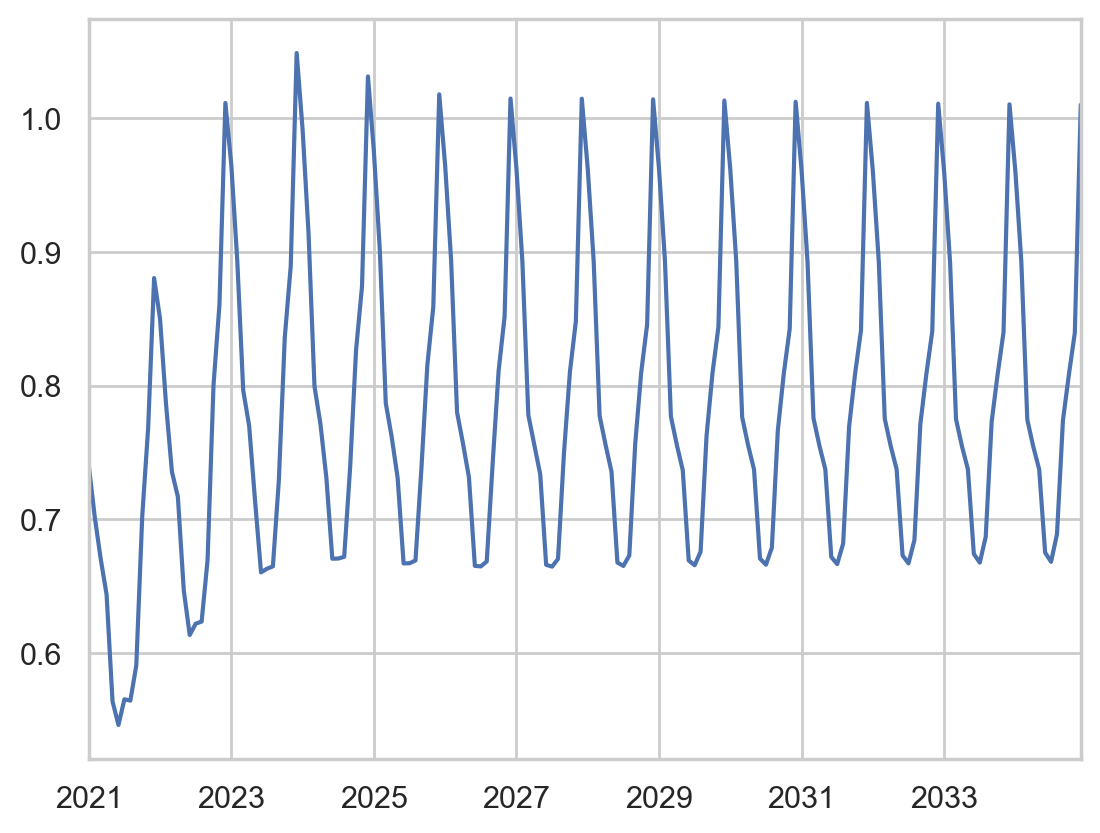

In [23]:
pred_date['var1(t)'].plot()

In [24]:
inv_pred = sc.inverse_transform(pred_date[['var1(t)', 'var2(t)', 'var3(t)']])
inv_pred = inv_pred[:,0]
inv_pred

array([713278.26380777, 677769.92337006, 648787.15600866, 623828.29626995,
       549978.84310532, 533594.29377514, 551395.31197149, 550461.38554561,
       574761.78165722, 677797.77296233, 739310.24278599, 842816.86462659,
       814581.29355359, 755923.32421589, 708796.2993269 , 691502.36430067,
       626562.13357198, 595890.46766955, 603721.60757232, 605132.2307815 ,
       647594.97286874, 768594.66810721, 824424.93874478, 963923.270679  ,
       920861.90022725, 854888.75293779, 765135.52815664, 740586.63647521,
       688486.61191809, 639174.41426861, 641727.86341953, 643351.02589327,
       702865.65971869, 801878.18458277, 850958.7067132 , 998501.32443953,
       945381.06729436, 873544.22971356, 767878.90601206, 741895.78790265,
       704636.34230989, 648649.06614918, 648758.25860995, 649964.28382444,
       711741.68323475, 793092.16212529, 837002.75212425, 982309.18546069,
       930348.18827409, 862008.43226659, 756265.68118381, 732839.4865309 ,
       704497.37008709, 6

In [25]:
# sub = pd.read_csv('submission_sample.csv')
# sub['IND'] = inv_pred
# sub.to_csv("test.csv", mode='w', index=False)

In [26]:
pred = pd.DataFrame()
pred['IND'] = inv_pred
pred.index = pred_date.index

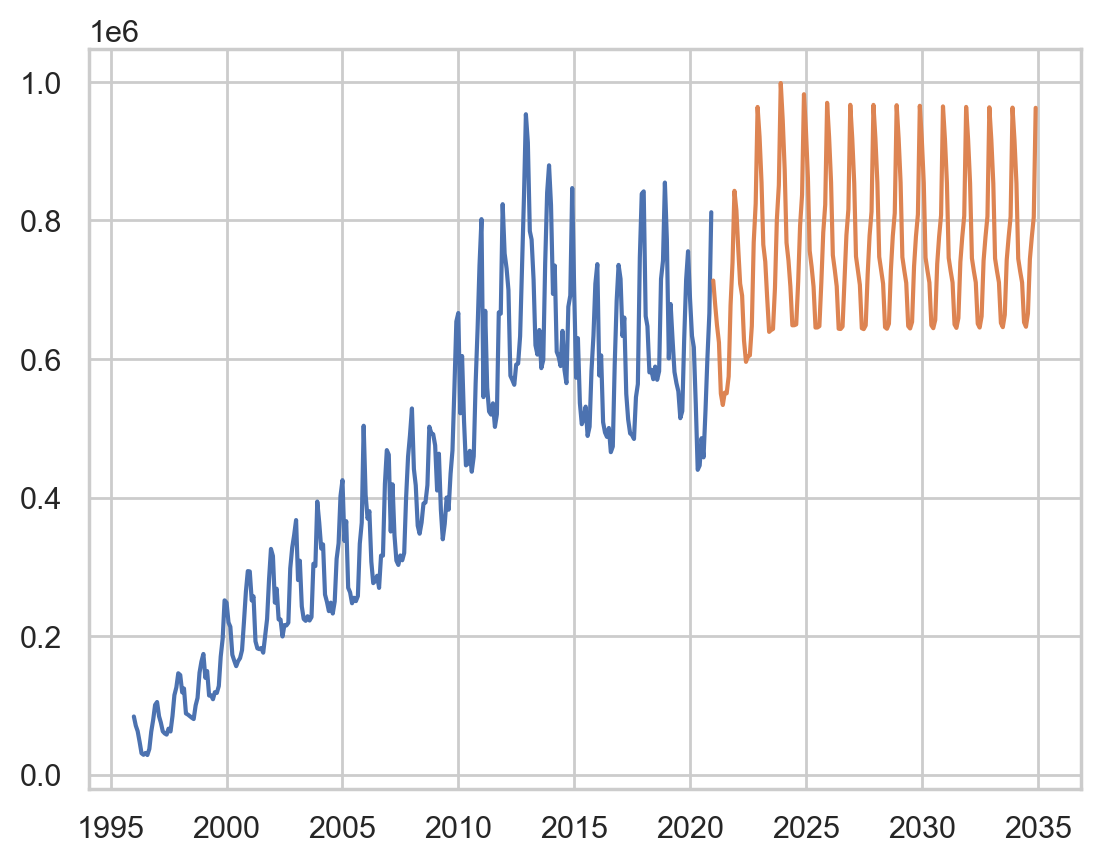

In [27]:
plt.figure()
plt.plot(ind['gas'])
plt.plot(pred)